# Logistic model

## Imports

In [1]:
# IMPORT THE NECESSARY LIBRARIES
import pandas as pd
import re # This module provides functions for working with regular expressions allowing search, match and manipulate strings based on patterns
import os # This module allows interaction with the operating system, such as working with files, directories, environment variables, and system commands.
import sys # This module provides access to system-specific parameters, including command-line arguments (sys.argv), standard input/output, and exiting the program (sys.exit()).
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from statsmodels.graphics.tsaplots import plot_acf # This function is used for plotting the Autocorrelation Function (ACF), which is helpful in time series analysis to measure how observations are correlated with their past values.
from mice_inspection_utils import * # Import all functions 
                                    # NOTICE: this is different from import mice_inspection_utils! In that case you'd have to use the module name as a prefic to access functions, classes or variables. E.g. mice_inspection_utils.some_function()

# This part avoids possible conflict due to the structure of mice_inspection_utils
if not os.path.exists('Data/by_mouse'): 
    os.makedirs('Data/by_mouse')

# GET THE NECESSARY DATA
imput_subj_paths = [f"Data/raw/total.full.rn.RA.total_OTU_table.mouse{i+1}.ovr0.0p.csv" for i in range(0, 8)]
output_subj_paths = [f"Data/by_mouse/mouse_{i+1}.csv" for i in range(0, 8)]
metadata_path = "Data/raw/OTU_table.csv"
mi = Mice_Inspection(ip = imput_subj_paths, op = output_subj_paths, mdp = metadata_path)

## Data structure

In [5]:
# By calling mice_df we have the dataframes for each mouse
df = mi.mice_df[0]
df.head() # -> As we can see we have the bacterial species, the median, the mean counts, and the counts per day (at day 1, 8, 9 ...)

# By calling get_species_df
df = mi.get_species_df(species = 'Prevotella sp. Smarlab 121567')
df.head(20) # -> As we can see we have the count per day of the selected species in each mouse

,day,mouse_1,mouse_2,mouse_3,mouse_4,mouse_5,mouse_6,mouse_7,mouse_8,mean,std
0,0,0,1,0,0,0,0,0,2,0.375,0.744024
1,1,0,0,0,0,0,0,0,1,0.125,0.353553
2,2,0,1,1,0,0,0,0,2,0.500,0.755929
3,3,0,0,0,0,2,0,0,0,0.250,0.707107
4,4,0,0,0,0,0,0,0,0,0.000,0.000000
5,5,0,0,0,0,0,0,0,0,0.000,0.000000
6,6,0,0,0,0,0,0,0,0,0.000,0.000000
7,7,0,0,0,0,0,0,0,0,0.000,0.000000
8,8,0,0,0,0,0,0,0,7,0.875,2.474874
9,9,0,0,9,0,1,60,0,0,8.750,20.940392


## Dissimilarity

First of all we create the dataframes with the dissimilarity values for each mouse. 

In [2]:
"""
# FIRST TRIAL
# Let's first do it on the first mice
df_1 = mi.mice_df[0]
df_1
# Let's set first T = 2 and for the first species
T = 2
days = df_1.columns[4:].to_numpy(dtype = int)
count = 0
for day in days: 
    if (day + T) in days: 
        count += 1
        diss_t = ((df_1[day][0] - df_1[day + T][0]) / (df_1[day][0] + df_1[day + T][0]) )**2
        print(diss_t)
        diss = diss_t
diss = diss/count
print("Dissimilarity species 1 of 1st mice:", diss)
"""
mice_diss = []
for mouse in range(1,9): 
    df = mi.get_dissimilarities(mouse)
    mice_diss.append(df)

Dissimilarities saved for mouse 1 at Data/dissimilarities/dissimilarity_1.csv
Dissimilarities saved for mouse 2 at Data/dissimilarities/dissimilarity_2.csv
Dissimilarities saved for mouse 3 at Data/dissimilarities/dissimilarity_3.csv
Dissimilarities saved for mouse 4 at Data/dissimilarities/dissimilarity_4.csv
Dissimilarities saved for mouse 5 at Data/dissimilarities/dissimilarity_5.csv
Dissimilarities saved for mouse 6 at Data/dissimilarities/dissimilarity_6.csv
Dissimilarities saved for mouse 7 at Data/dissimilarities/dissimilarity_7.csv
Dissimilarities saved for mouse 8 at Data/dissimilarities/dissimilarity_8.csv


Let's now have a graphical visualization of these dissimilarities

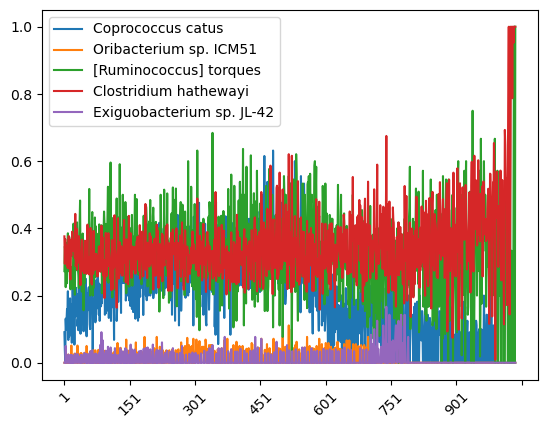

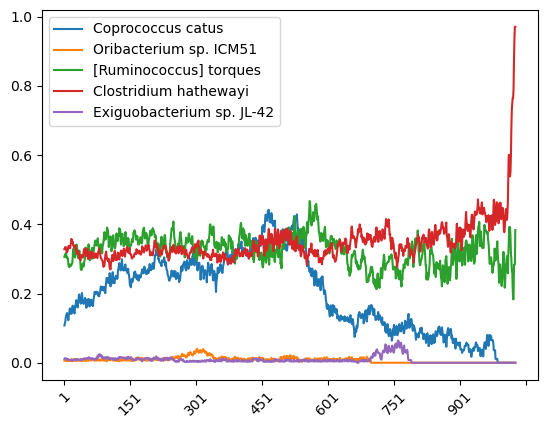

In [5]:
# For the first mice (mice_diss[0])
species = np.asarray(mice_diss[0].index)
n_species = 5
rnd_idx = np.random.choice(np.arange(len(species)), n_species)
species = species[rnd_idx]
lags = np.asarray(mice_diss[0].columns)

for sp in species: 
    data = mice_diss[0].loc[sp].values
    plt.plot(lags, data, label = sp)
plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))
plt.xticks(rotation=45)
plt.legend()
plt.show()

# Let's smooth the data a bit for better visualization
def moving_average(data, window_size=5): #This means that for each point t, we take the average of the previous W points.
    return np.convolve(data, np.ones(window_size)/window_size, mode='valid')

for sp in species: 
    data = mice_diss[0].loc[sp].values
    smoothed_data = moving_average(data, window_size=10)
    plt.plot(lags[:len(smoothed_data)], smoothed_data, label=sp)
plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))
plt.xticks(rotation=45)
plt.legend()
plt.show()   


In [6]:
# Let's make one file per mouse where I get one or more pages of graphs in which I can see 
"""
from matplotlib.backends.backend_pdf import PdfPages

def moving_average(data, window_size=5):
    return np.convolve(data, np.ones(window_size)/window_size, mode='valid')

def plot_dissimilarities_in_pdf(mice_diss, output_dir="Inspection_Outputs", n_species_per_plot=5, window_size=10, ma = True):
    os.makedirs(output_dir, exist_ok=True)  # Ensure the output directory exists
    
    for mouse_idx, df in enumerate(mice_diss):  # Iterate through each mouse's dataframe
        pdf_path = os.path.join(output_dir, f"dissimilarity_{mouse_idx + 1}_plot.pdf")
        species = np.asarray(df.index)  # Get all species
        lags = np.asarray(df.columns)  # Get lags
        
        with PdfPages(pdf_path) as pdf:
            for i in range(0, len(species), n_species_per_plot):
                selected_species = species[i:i + n_species_per_plot]
                
                plt.figure(figsize=(10, 6))
                for sp in selected_species:
                    data = df.loc[sp].values
                    if ma: 
                        smoothed_data = moving_average(data, window_size=window_size)
                        plt.plot(lags[:len(smoothed_data)], smoothed_data, label=sp)
                    else: 
                        plt.plot(lags, data, label=sp)
                
                plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))
                plt.xticks(rotation=45)
                plt.legend()
                plt.xlabel("Lags")
                plt.ylabel("Smoothed Values")
                plt.title(f"Mouse {mouse_idx + 1}: Species {i+1} to {min(i+n_species_per_plot, len(species))}")
                pdf.savefig()
                plt.close()
        
        print(f"Plots saved in {pdf_path}")
"""

'\nfrom matplotlib.backends.backend_pdf import PdfPages\n\ndef moving_average(data, window_size=5):\n    return np.convolve(data, np.ones(window_size)/window_size, mode=\'valid\')\n\ndef plot_dissimilarities_in_pdf(mice_diss, output_dir="Inspection_Outputs", n_species_per_plot=5, window_size=10, ma = True):\n    os.makedirs(output_dir, exist_ok=True)  # Ensure the output directory exists\n    \n    for mouse_idx, df in enumerate(mice_diss):  # Iterate through each mouse\'s dataframe\n        pdf_path = os.path.join(output_dir, f"dissimilarity_{mouse_idx + 1}_plot.pdf")\n        species = np.asarray(df.index)  # Get all species\n        lags = np.asarray(df.columns)  # Get lags\n        \n        with PdfPages(pdf_path) as pdf:\n            for i in range(0, len(species), n_species_per_plot):\n                selected_species = species[i:i + n_species_per_plot]\n                \n                plt.figure(figsize=(10, 6))\n                for sp in selected_species:\n                  

In [ ]:
plot_dissimilarities_in_pdf(mice_diss, n_species_per_plot=5, window_size=10, ma = True)

Plots saved in Inspection_Outputs/dissimilarity_1_plot.pdf
Plots saved in Inspection_Outputs/dissimilarity_2_plot.pdf
Plots saved in Inspection_Outputs/dissimilarity_3_plot.pdf
Plots saved in Inspection_Outputs/dissimilarity_4_plot.pdf
Plots saved in Inspection_Outputs/dissimilarity_5_plot.pdf
Plots saved in Inspection_Outputs/dissimilarity_6_plot.pdf
Plots saved in Inspection_Outputs/dissimilarity_7_plot.pdf
Plots saved in Inspection_Outputs/dissimilarity_8_plot.pdf
